In [ ]:
import numpy as np

# 参数
q = 0.1  # FL 训练每个客户端都使用所有数据
T = 100 # 训练轮数
delta = 1e-4  # 隐私失败概率
C = 1.0
eta = 0.03
datasize = 2800
# 计算不同 σ 的 ε
for epsilon in [0.0005, 0.005, 0.05, 0.116, 0.5, 0.6, 0.65, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 12.0, 14.0, 16.0, 24.0, 48.0, 64.0, 90.0, 96.0, 120.0]:
    sigma = (C * q * np.sqrt(T * np.log(1 / delta))) / epsilon
    print(f"σ={sigma:.5f}: ε={epsilon}")

σ=6069.70852: ε=0.0005
σ=606.97085: ε=0.005
σ=60.69709: ε=0.05
σ=26.16254: ε=0.116
σ=6.06971: ε=0.5
σ=5.05809: ε=0.6
σ=4.66901: ε=0.65
σ=3.03485: ε=1.0
σ=1.51743: ε=2.0
σ=1.01162: ε=3.0
σ=0.75871: ε=4.0
σ=0.60697: ε=5.0
σ=0.50581: ε=6.0
σ=0.43355: ε=7.0
σ=0.37936: ε=8.0
σ=0.30349: ε=10.0
σ=0.25290: ε=12.0
σ=0.21678: ε=14.0
σ=0.18968: ε=16.0
σ=0.12645: ε=24.0
σ=0.06323: ε=48.0
σ=0.04742: ε=64.0
σ=0.03372: ε=90.0
σ=0.03161: ε=96.0
σ=0.02529: ε=120.0


In [34]:
from opacus.accountants import RDPAccountant
NORM_BOUND = 5.0
SIGMA = 0.25
DELTA = 1e-4
P = 0.005
accountant = RDPAccountant()
N_ROUND = 100
N_EPOCH = 3
for i in range(N_ROUND):
    for j in range(N_EPOCH):
        accountant.step(noise_multiplier=SIGMA, sample_rate=P)
print(accountant.get_epsilon(delta=DELTA))

46.21399234852107


In [32]:
from autodp.mechanism_zoo import ExactGaussianMechanism
from autodp.transformer_zoo import AmplificationBySampling, Composition

# 设置参数
sigma = 0.25   # 例如 0.5
p = 0.005              # 子采样比例
T = 300                # 总共训练的轮数
delta = 1e-4           # 目标delta

gm = ExactGaussianMechanism(sigma, name='GM')

poisson_sample = AmplificationBySampling(PoissonSampling=True)
gm_poisson_sampled = poisson_sample(gm, p)
compose = Composition()
composed_mech_poisson = compose([gm_poisson_sampled], [T])
epsilon_poisson = composed_mech_poisson.get_approxDP(delta)

gm.neighboring = "replace_one"
subsample = AmplificationBySampling(PoissonSampling=False)
gm_subsampled = subsample(gm, p)
composed_mech_sub = compose([gm_subsampled], [T])
epsilon_sub = composed_mech_sub.get_approxDP(delta)

print(f'最终 poisson epsilon (给定 delta={delta}) = {epsilon_poisson}')
print(f'最终 subsample epsilon (给定 delta={delta}) = {epsilon_sub}')


最终 poisson epsilon (给定 delta=0.0001) = 1630.1809842600358
最终 subsample epsilon (给定 delta=0.0001) = 1837.4522325866105


In [33]:

from autodp.mechanism_zoo import ExactGaussianMechanism, PureDP_Mechanism
from autodp.transformer_zoo import Composition, AmplificationBySampling
import matplotlib.pyplot as plt

sigma1 = 5.0
sigma2 = 8.0

gm1 = ExactGaussianMechanism(sigma1,name='GM1')
gm2 = ExactGaussianMechanism(sigma2,name='GM2')
SVT = PureDP_Mechanism(eps=0.1,name='SVT')

# run gm1 for 3 rounds
# run gm2 for 5 times
# run SVT for once

# compose them with the transformation: compose.
compose = Composition()

poisson_sample = AmplificationBySampling(PoissonSampling=True)
subsample = AmplificationBySampling(PoissonSampling=False)

prob = 0.1
coeffs = [30,50,10]

composed_mech = compose([gm1, gm2, SVT], coeffs)

composed_poissonsampled_mech = compose([poisson_sample(gm1,prob),
                                        poisson_sample(gm2,prob),
                                        poisson_sample(SVT,prob)],
                                       coeffs)

composed_poissonsampled_mech1 = compose([poisson_sample(gm1,prob,improved_bound_flag=True),
                                        poisson_sample(gm2,prob,improved_bound_flag=True),
                                        poisson_sample(SVT,prob,improved_bound_flag=True)],
                                       coeffs)



# Now let's do subsampling. First we need to use replace-one version of the base mechanisms.
gm1.neighboring = "replace_one"
gm2.neighboring = "replace_one"
SVT.neighboring = "replace_one"

composed_subsampled_mech = compose([subsample(gm1,prob),
                                    subsample(gm2,prob),
                                    subsample(SVT,prob)],
                                   coeffs)

composed_subsampled_mech1 = compose([subsample(gm1,prob,improved_bound_flag=True),
                                    subsample(gm2,prob,improved_bound_flag=True),
                                    subsample(SVT,prob,improved_bound_flag=True)],
                                   coeffs)

# Query for eps given delta
delta1 = 1e-6
eps1 = composed_mech.get_approxDP(delta1)

delta2 = 1e-4
eps2 = composed_mech.get_approxDP(delta2)


# Get name of the composed object, a structured description of the mechanism generated automatically
print('---------------------------------------------------')
print('Mechanism name is \"', composed_mech.name,'\"')
print('Parameters are: ',composed_mech.params)
print('epsilon(delta) = ', eps1, ', at delta = ', delta1)
print('epsilon(delta) = ', eps2, ', at delta = ', delta2)


eps1a = composed_poissonsampled_mech.get_approxDP(delta1)
eps2a = composed_poissonsampled_mech.get_approxDP(delta2)

eps1aa = composed_poissonsampled_mech1.get_approxDP(delta1)
eps2aa = composed_poissonsampled_mech1.get_approxDP(delta2)

# Get name of the composed object, a structured description of the mechanism generated automatically
print('---------------------------------------------------')
print('Mechanism name is \"', composed_poissonsampled_mech.name,'\"')
print('Parameters are: ',composed_poissonsampled_mech.params)
print('epsilon(delta) = ', eps1a, ', at delta = ', delta1)
print('epsilon(delta) = ', eps2a, ', at delta = ', delta2)
print('------- If qualified for the improved bounds --------')
print('epsilon(delta) = ', eps1aa, ', at delta = ', delta1)
print('epsilon(delta) = ', eps2aa, ', at delta = ', delta2)


eps1b = composed_subsampled_mech.get_approxDP(delta1)
eps2b = composed_subsampled_mech.get_approxDP(delta2)

eps1bb = composed_subsampled_mech1.get_approxDP(delta1)
eps2bb = composed_subsampled_mech1.get_approxDP(delta2)

# Get name of the composed object, a structured description of the mechanism generated automatically
print('---------------------------------------------------')
print('Mechanism name is \"', composed_subsampled_mech.name,'\"')
print('Parameters are: ',composed_subsampled_mech.params)
print('epsilon(delta) = ', eps1b, ', at delta = ', delta1)
print('epsilon(delta) = ', eps2b, ', at delta = ', delta2)
print('------- If qualified for the improved bounds --------')
print('epsilon(delta) = ', eps1bb, ', at delta = ', delta1)
print('epsilon(delta) = ', eps2bb, ', at delta = ', delta2)

# # Get hypothesis testing interpretation so we can directly plot it
# fpr_list, fnr_list = composed_mech.plot_fDP()
#
# plt.figure(figsize = (6,6))
# plt.plot(fpr_list,fnr_list)
# plt.xlabel('Type I error')
# plt.ylabel('Type II error')
# plt.show()


/home/wzj/anaconda3/envs/privimage/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2989: RuntimeWarning: invalid value encountered in scalar divide
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


---------------------------------------------------
Mechanism name is " Compose:{GM1: 30, GM2: 50, SVT: 10} "
Parameters are:  {'GM1:sigma': 5.0, 'GM2:sigma': 8.0, 'SVT:eps': 0.1}
epsilon(delta) =  7.942374861004204 , at delta =  1e-06
epsilon(delta) =  6.457460671942037 , at delta =  0.0001
---------------------------------------------------
Mechanism name is " Compose:{PoissonSample:GM1: 30, PoissonSample:GM2: 50, PoissonSample:SVT: 10} "
Parameters are:  {'PoissonSample:GM1:sigma': 5.0, 'PoissonSample:GM1:PoissonSample': 0.1, 'PoissonSample:GM2:sigma': 8.0, 'PoissonSample:GM2:PoissonSample': 0.1, 'PoissonSample:SVT:eps': 0.1, 'PoissonSample:SVT:PoissonSample': 0.1}
epsilon(delta) =  0.8616498207977256 , at delta =  1e-06
epsilon(delta) =  0.6454038954384236 , at delta =  0.0001
------- If qualified for the improved bounds --------
epsilon(delta) =  0.6689293610040956 , at delta =  1e-06
epsilon(delta) =  0.4895066897613118 , at delta =  0.0001
---------------------------------------

In [ ]:
#table 1
info_dict = {
    "CLDP-MNIST-" : {
        "MK" : {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/CLDP-delta/MNIST/dpsgd-dira500/2attack-krum-res11.4/res/Accurancy.pkl",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/CLDP-delta/MNIST/dpsgd-dira500/baseline-krum-res96.3/res/Accurancy.pkl",
        },
        "TM" :{
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/CLDP-delta/MNIST/dpsgd-dira500/2attack-tm-res74.9/res/Accurancy.pkl",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/CLDP-delta/MNIST/dpsgd-dira500/baseline-trimmedmean-res97.3/res/Accurancy.pkl",
        },
    },
    "CLDP-FMNIST-": {
        "MK" : {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/CLDP-delta/FMNIST/dpsgd-dira500/2attack-krum/res/Accurancy.pkl",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/CLDP-delta/FMNIST/dpsgd-dira500/baseline-krum/res/Accurancy.pkl",
        },
        "TM" : {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/CLDP-delta/FMNIST/dpsgd-dira500/2attack-tm/res/Accurancy.pkl",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/CLDP-delta/FMNIST/dpsgd-dira500/baseline-tm/res/Accurancy.pkl",
        },
    },
    "CLDP-CIFAR10-VGG-": {
        "TM" : {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/CLDP-delta/cigar10-vggmini/tm-2attack/res/Accurancy.pkl",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/CLDP-delta/cigar10-vggmini/baseline/res/Accurancy.pkl",
        },
    },
    "CLDP-CIFAR10-Resnet-": {
        "MK" : {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/CLDP-delta/cifar10-resnet/CIFAR10-1/dpsgd-norm1-attack2-attacknorm3.0/res/Accurancy.pkl",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/CLDP-delta/cifar10-resnet/CIFAR10-1/dpsgd-norm1-eps100/res/Accurancy.pkl",
        }
    },
    "LDPFL-CIFAR10-Resnet-": {
        "FPA" : {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/front-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/baseline-ep50/res/Accurancy.pkl",
        },
        "OFPA" : {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/front-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/baseline-ep50/res/Accurancy.pkl",
        },
        "BPA" : {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/back-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/baseline-ep50/res/Accurancy.pkl",
        },
        "OBPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/back-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/baseline-ep50/res/Accurancy.pkl",
        },
        "RA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/noise-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/baseline-ep50",
        },
        "MK": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/2attack-mk",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/baseline-mk",
        },
    },
    "LDPFL-CIFAR10-VGGMini-": {
        "FPA" : {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/front-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/baseline/res/Accurancy.pkl",
        },
        "OFPA" : {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/front-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/baseline/res/Accurancy.pkl",
        },
        "BPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/back-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/baseline/res/Accurancy.pkl",
        },
        "OBPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/back-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/baseline/res/Accurancy.pkl",
        },
        "RA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/noise-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/baseline",
        },
        "MK": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/mk-2attack/res/Accurancy.pkl",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/baseline-mk",
        },
    },
    "LDPFL-FMNIST-": {
        "FPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/front-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/baseline/res/Accurancy.pkl",
        },
        "OFPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/front-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/baseline/res/Accurancy.pkl",
        },
        "BPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/back-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/baseline/res/Accurancy.pkl",
        },
        "OBPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/back-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/baseline/res/Accurancy.pkl",
        },
        "RA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/noise-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/baseline/res/Accurancy.pkl",
        },
        "MK": {
            "20% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/4attack-krum/res/Accurancy.pkl",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/baseline/res/Accurancy.pkl",
        },
    },
    "LDPFL-MNIST-": {
        "FPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/front-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/baseline/res/Accurancy.pkl",
        },
        "OFPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/front-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/baseline/res/Accurancy.pkl",
        },
        "BPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/back-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/baseline/res/Accurancy.pkl",
        },
        "OBPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/back-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/baseline/res/Accurancy.pkl",
        },
        "RA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/noise-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/baseline/res/Accurancy.pkl",
        },
        "MK": {
            "20% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/select-attack-ldpfl/4attack-a500-res78.3/res/Accurancy.pkl",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/select-attack-ldpfl/0attack-a500-res91.9/res/Accurancy.pkl",
        },
    },
    "DPSGD-MNIST-" : {
        "FPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/front-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/baseline",
        },
        "OFPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/front-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/baseline",
        },
        "BPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/back-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/baseline",
        },
        "OBPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/back-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/baseline",
        },
        "RA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/RA/random-scale50.0",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/baseline",
        },
        "MK": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/baseline",
        },
        "TM": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/tm-2attack-fitpart",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/baseline",
        },
    },
    "DPSGD-FMNIST-" : {
        "BPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/back-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/baseline",
        },
        "FPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/front-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/baseline",
        },
        "OFPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/front-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/baseline",
        },
        "OBPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/loss-total-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/baseline",
        },
        "RA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/RA/random-scale50.0",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/baseline",
        },
        "MK": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/mk-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/baseline-mk",
        },
        "TM": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/tm-2attackfitpart",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/baseline-tm",
        },
    },
    "DPSGD-CIFAR10-Resnet-" : {
        "FPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/front-2attack-epoch20",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/baseline",
        },
        "OFPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/front-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/baseline",
        },
        "BPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/back-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/baseline",
        },
        "OBPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/loss-total-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/baseline",
        },
        "RA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/random-scale25.0",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/baseline",
        },
        "MK": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/km-2attack-scale1.0",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/baseline-mk",
        },
        "TM": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/tm-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/baseline-tm",
        },
    },
    "DPSGD-CIFAR10-VGGMini-" : {
        "FPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/front-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/baseline",
        },
        "OFPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/front-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/baseline",
        },
        "BPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/back-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/baseline",
        },
        "OBPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/back-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/baseline",
        },
        "RA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/RA/random-scale25.0",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/baseline",
        },
        "MK": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/2attack-mk",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/baseline",
        },
        "TM": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/2attack-tm-fitall",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/baseline",
        },
    },
    "PrivFL-MNIST-": {
        "FPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/front-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/baseline",
        },
        "OFPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/front-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/baseline",
        },
        "BPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/back-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/baseline",
        },
        "OBPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/back-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/baseline",
        },
        "RA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/noise-2attack-scale50",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/baseline",
        },
        "MK": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/mk-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/baseline",
        },
        "TM": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/tm-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/baseline",
        },
    },
    "PrivFL-FMNIST-": {
        "FPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/front-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/baseline",
        },
        "OFPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/front-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/baseline",
        },
        "BPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/back-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/baseline",
        },
        "OBPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/loss-total-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/baseline",
        },
        "RA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/noise-2attack-scale50.0",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/baseline",
        },
        "MK": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/mk-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/baseline",
        },
        "TM": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/tm-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/baseline",
        },
    },
    "PrivFL-CIFAR10-VGGMini-": {
        "FPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/front-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/baseline",
        },
        "OFPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/front-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/baseline",
        },
        "BPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/back-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/baseline",
        },
        "OBPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/back-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/baseline",
        },
        "RA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/noise-2attack-scale50.0",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/baseline",
        },
        "MK": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/mk-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/baseline",
        },
        "TM": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/tm-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/baseline",
        },
    },
    "PrivFL-CIFAR10-Resnet-": {
        "FPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/front-2attack-epoch20",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/baseline",
        },
        "OFPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/front-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/baseline",
        },
        "BPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/back-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/baseline",
        },
        "OBPA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/back-tl-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/baseline",
        },
        "RA": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/noise-2attack-scale25.0",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/baseline",
        },
        "MK": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/mk-2attack",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/baseline",
        },
        "TM": {
            "10% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/tm-2attack-fitall-same",
            "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/baseline",
        },
    },
        "": {
            "10% attacker":"",
            "0% attacker":"",
        },
}

from result.result import plot_accuracy_curves
prefix = "DPSGD-CIFAR10-VGGMini-"
name = "RA"
save_path = "./result/figure/{}{}.png".format(prefix, name)
caption = "{}{}".format(prefix, name)
assert prefix in info_dict.keys() and name in info_dict[prefix].keys()
plot_accuracy_curves(info_dict[prefix][name], save_path=save_path, caption=caption)

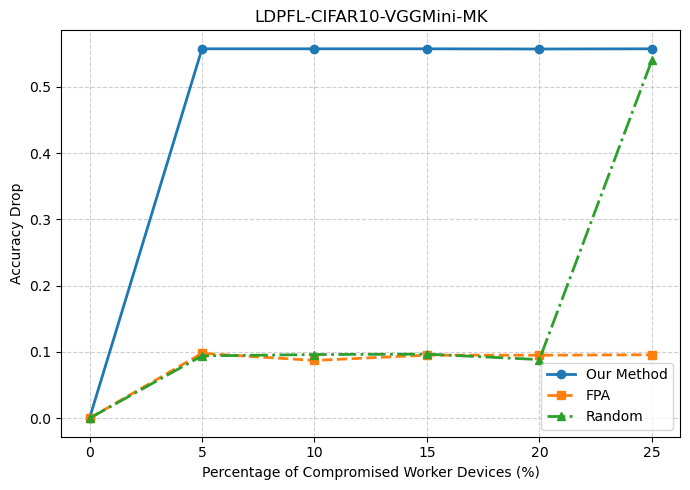

In [5]:
#figure 2
method2acc = {
    "DPSGD-MNIST-" : {
        "MK" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/mk-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/mk-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/mk-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/mk-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/mk-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/noise-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/noise-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/noise-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/noise-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/mk/noise-5attack",
            }
        },
        "TM" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/tm-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/tm-2attack-fitpart",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/tm-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/tm-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/tm-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/noise-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/noise-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/noise-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/noise-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/TM/noise-5attack",
            }
        }
    },
    "DPSGD-FMNIST-" : {
        "MK" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/mk-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/mk-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/mk-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/mk-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/mk-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/noise-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/noise-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/noise-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/noise-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/MK/noise-5attack",
            }
        },
        "TM" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/tm-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/tm-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/tm-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/tm-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/tm-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/random-1attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/random-5attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/FMNIST/TM/random-2attack",
            }
        } 
    },
    "DPSGD-CIFAR10-Resnet-" : {
        "MK" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/mk-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/mk-2attack-scale1.0",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/mk-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/mk-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/mk-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/random-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/MK/random-5attack",
            }
        },
        "TM" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/tm-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/tm-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/tm-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/tm-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/tm-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/random-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-resnet/TM/random-5attack",
            }
        }
    },
    "DPSGD-CIFAR10-VGGMini-" : {
        "MK" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/mk-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/mk-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/mk-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/mk-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/mk-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/random-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/MK/random-5attack",
            }
        },
        "TM" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/tm-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/tm-2attack-fitpart",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/tm-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/tm-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/tm-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/random-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/DPSGD/CIFAR10-VGG_Mini/TM/random-5attack",
            }
        }
    },
    "PrivFL-MNIST-" : {
        "MK" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/mk-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/mk-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/mk-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/mk-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/mk-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/random-2attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/random-5attack",
            }
        },
        "TM" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/tm-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/tm-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/tm-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/tm-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/tm-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/random-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/TM/random-5attack",
            }
        }
    },
    "PrivFL-FMNIST-" : {
        "MK" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/mk-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/mk-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/mk-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/mk-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/mk-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/random-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/MK/random-5attack",
            }
        },
        "TM" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/tm-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/tm-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/tm-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/tm-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/tm-5attack", #TODO
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/random-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/FMNIST/TM/random-5attack",
            }
        }
    },
    "PrivFL-CIFAR10-Resnet-" : {
        "MK" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/MK/mk-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/MK/mk-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/MK/mk-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/MK/mk-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/MK/mk-5attack",
            },
        },
        "TM" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/tm-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/tm-2attack-fitpart",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/tm-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/tm-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/tm-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/random-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-ResNet/TM/random-5attack",
            }
        }
    },
    "PrivFL-CIFAR10-VGGMini-" : {
        "MK" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/mk-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/mk-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/mk-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/mk-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/mk-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/random-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/MK/random-5attack",
            }
        },
        "TM" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/tm-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/tm-2attack-fitall",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/tm-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/tm-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/tm-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/fpa-5attack",
            },
            "Random" : {
                "0% attacker":"/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/tm-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/random-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/PrivFL/CIFAR10-VGGMini/TM/random-5attack",
            }
        }
    },
    "LDPFL-MNIST-" : {
        "MK" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/mk-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/mk-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/mk-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/mk-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/mk-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/random-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/MNIST-ldpfl/MK/random-5attack",
            }
        }
    },
    "LDPFL-FMNIST-" : {
        "MK" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/mk-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/mk-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/mk-3attack-2",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/mk-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/mk-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/random-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/FMNIST-ldpfl/MK/random-5attack",
            }
        }
    },
    "LDPFL-CIFAR10-Resnet-" : {
        "MK" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/mk-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/mk-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/mk-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/mk-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/mk-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/mk-0attack",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/random-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-resnet/MK/random-5attack",
            }
        }
    },
    "LDPFL-CIFAR10-VGGMini-" : {
        "MK" : {
            "Our Method" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/mk-0attack-2",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/mk-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/mk-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/mk-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/mk-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/mk-5attack",
            },
            "FPA" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/mk-0attack-2",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/fpa-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/fpa-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/fpa-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/fpa-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/fpa-5attack",
            },
            "Random" : {
                "0% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/mk-0attack-2",
                "5% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/random-1attack",
                "10% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/random-2attack",
                "15% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/random-3attack",
                "20% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/random-4attack",
                "25% attacker":  "/home/wzj/FLattack/FedField/log_res/LDPFL/CIFAR10-ldpfl-vggmini/MK/random-5attack",
            }
        }
    },
}

from result.result import plot_accuracy_drop
prefix = "LDPFL-CIFAR10-VGGMini-"
name = "MK"
save_path = "./result/figure/{}{}.png".format(prefix, name)
caption = "{}{}".format(prefix, name)
assert prefix in method2acc.keys() and name in method2acc[prefix].keys()
plot_accuracy_drop(method2acc[prefix][name], save_path=save_path, caption=caption)

/home/wzj/FLattack/FedField/src/result/result.py:117: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[j], edgecolor='black') for j in range(len(attacker_counts))


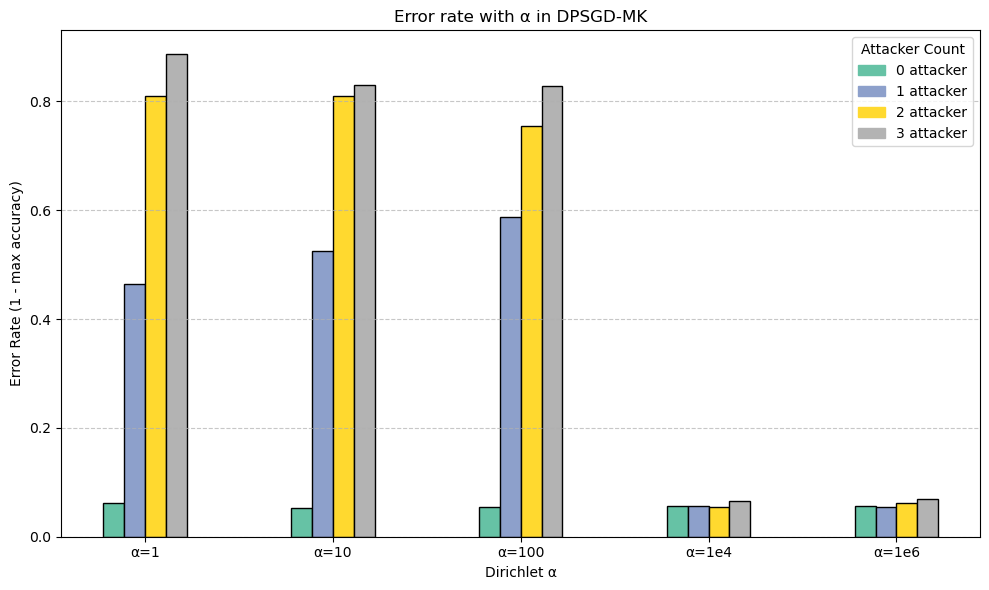

In [ ]:
a2err = {
    "DPSGD-TM" : {
        "a 1" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a1-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a1-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a1-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a1-3attack",
        },
        "a 10" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a10-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a10-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a10-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a10-3attack",
        },
        "a 100" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a100-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a100-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a100-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a100-3attack",
        },
        "a 1e4" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a1e4-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a1e4-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a1e4-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a1e4-3attack",
        },
        "a 1e6" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a1e6-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a1e6-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a1e6-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/TM/a1e6-3attack",
        }
    },
    "PrivFL-TM" : {
        "a 1" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a1-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a1-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a1-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a1-3attack",
        },
        "a 10" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a10-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a10-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a10-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a10-3attack",
        },
        "a 100" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a100-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a100-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a100-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a100-3attack",
        },
        "a 1e4" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a1e4-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a1e4-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a1e4-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a1e4-3attack",
        },
        "a 1e6" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a1e6-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a1e6-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a1e6-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/NonIID/TM/a1e6-3attack",
        }
    },
    "DPSGD-MK" : {
        "a 1" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a1-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a1-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a1-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a1-3attack",
        },
        "a 10" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a10-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a10-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a10-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a10-3attack",
        },
        "a 100" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a100-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a100-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a100-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a100-3attack",
        },
        "a 500" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/mk-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/mk-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/mk-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/PrivFL/MNIST/MK/mk-3attack",
        },
        "a 1e4" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a1e4-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a1e4-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a1e4-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a1e4-3attack",
        },
        "a 1e6" : {
            "0 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a1e6-0attack",
            "1 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a1e6-1attack",
            "2 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a1e6-2attack",
            "3 attacker" : "/home/wzj/FLattack/FedField/log_res/DPSGD/MNIST/NonIID/MK/a1e6-3attack",
        }
    }
}

from result.result import plot_error_rate_bars
prefix = "DPSGD-MK"
save_path = "./result/figure/a2error-{}.png".format(prefix)
caption = "Error rate with \u03B1 in {}".format(prefix)
assert prefix in a2err.keys()
plot_error_rate_bars(a2err[prefix], save_path=save_path, caption=caption)

图片已保存至: ./dataset/FashionMNIST/dirichlet_20users_a500_seed98_public0.05/label_distribution.png


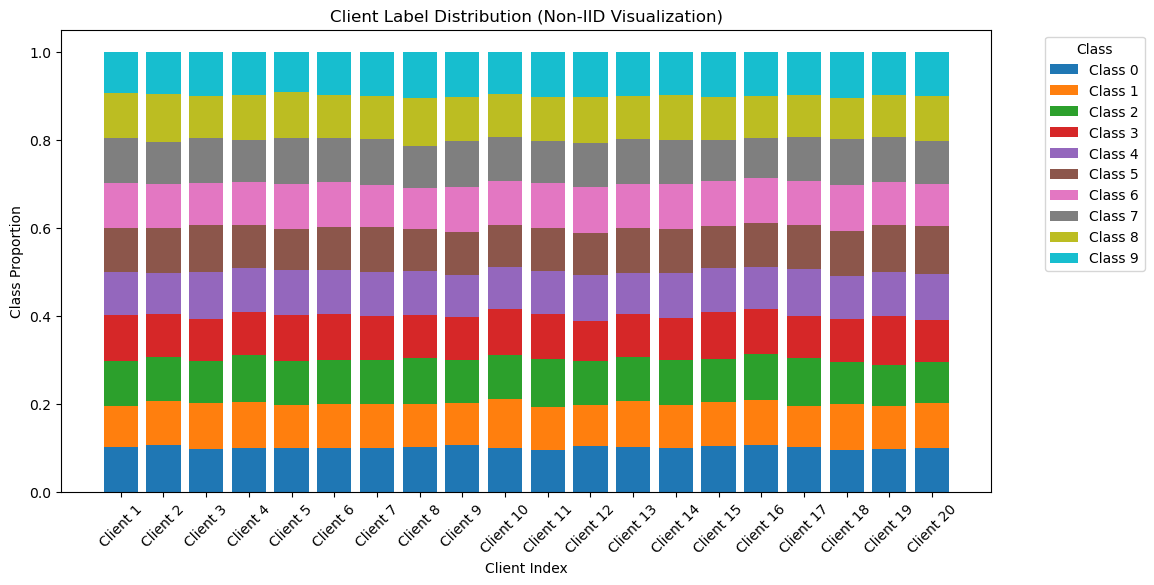

In [1]:
from result.client import plot_client_label_distribution
dir = "./dataset/FashionMNIST/dirichlet_20users_a500_seed98_public0.05"
plot_client_label_distribution(20, dir, dir, save_name="label_distribution.png")